Get stock data from yahoo finance

In [407]:
from datetime import datetime
import pandas as pd

In [408]:
'''Convert date to the epoch time'''
def date_to_epoch(date):
    return int(date.timestamp())

In [409]:
import pandas as pd
'''Get the public stock price data for a given ticker'''
def get_stock_price(ticker:str, start_date :datetime, end_date :datetime) -> pd.DataFrame:
    if not start_date:
        start_date = datetime(2020, 1, 1)
    if not end_date:
        end_date = datetime.now()

    url = f"https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={date_to_epoch(start_date)}&period2={date_to_epoch(end_date)}&interval=1d&events=history&includeAdjustedClose=true"
    df = pd.read_csv(url)
    df = df.set_index("Date")
    df.index = pd.to_datetime(df.index)
    return df
        

In [410]:
df_data = get_stock_price("MSFT", datetime(2020, 1, 1), datetime.now())

In [411]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 844 entries, 2019-12-31 to 2023-05-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       844 non-null    float64
 1   High       844 non-null    float64
 2   Low        844 non-null    float64
 3   Close      844 non-null    float64
 4   Adj Close  844 non-null    float64
 5   Volume     844 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 46.2 KB


In [412]:
df_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-31,156.770004,157.770004,156.449997,157.699997,152.930145,18369400
2020-01-02,158.779999,160.729996,158.330002,160.619995,155.761810,22622100
2020-01-03,158.320007,159.949997,158.059998,158.619995,153.822311,21116200
2020-01-06,157.080002,159.100006,156.509995,159.029999,154.219879,20813700
2020-01-07,159.320007,159.669998,157.320007,157.580002,152.813736,21634100


In [413]:
df_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-02,307.760010,309.179993,303.910004,305.410004,305.410004,26404400
2023-05-03,306.619995,308.609985,304.089996,304.399994,304.399994,22360800
2023-05-04,306.239990,307.760010,303.399994,305.410004,305.410004,22519900
2023-05-05,305.720001,311.970001,304.269989,310.649994,310.649994,28181200
2023-05-08,310.130005,310.200012,306.089996,308.649994,308.649994,21306900


In [414]:
df_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,844.000000,844.000000,844.000000,844.000000,844.000000,8.440000e+02
mean,247.718531,250.515201,244.885379,247.829123,244.498424,3.158820e+07
std,46.184296,46.228201,45.907819,46.117691,46.679300,1.328659e+07
min,137.009995,140.570007,132.520004,135.419998,131.682693,9.200800e+06
25%,214.332496,216.362495,212.452503,214.312503,209.904571,2.289520e+07
50%,247.869996,251.019996,245.825005,248.735001,246.888809,2.833020e+07
75%,284.094994,287.629997,280.504989,284.012497,281.709702,3.542355e+07
max,344.619995,349.670013,342.200012,343.109985,339.075531,9.701270e+07


<Axes: xlabel='Date'>

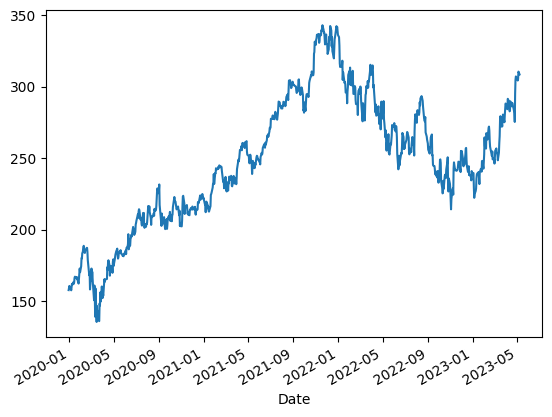

In [415]:
df_data['Close'].plot()

We generate the trading strategy base on the CLHL
It is the close price minus the low price divided by the high price minus the low price.

Define the threshold and if the clhl is lower than the threshold, hold the stock, otherwise don't hold it.


In [416]:
clhl_threshold = 0.5
tc = 0.005  # transaction cost
df_data['CLHL'] = (df_data['Close'] - df_data['Low']) / (df_data['High'] - df_data['Low'])
df_data['Return'] = df_data['Close'].pct_change()

In [417]:
df_data['holding'] = df_data['CLHL'] < clhl_threshold
df_data['holding'] = df_data['holding'].astype(int)
df_data['holding-1'] = df_data['holding'].shift(1)

In [418]:
df_data.head(5)

,Open,High,Low,Close,Adj Close,Volume,CLHL,Return,holding,holding-1
Date,,,,,,,,,,
2019-12-31,156.770004,157.770004,156.449997,157.699997,152.930145,18369400,0.946965,NaN,0,NaN
2020-01-02,158.779999,160.729996,158.330002,160.619995,155.761810,22622100,0.954166,0.018516,0,0.0
2020-01-03,158.320007,159.949997,158.059998,158.619995,153.822311,21116200,0.296295,-0.012452,1,0.0
2020-01-06,157.080002,159.100006,156.509995,159.029999,154.219879,20813700,0.972970,0.002585,0,1.0
2020-01-07,159.320007,159.669998,157.320007,157.580002,152.813736,21634100,0.110637,-0.009118,1,0.0


In [419]:
df_data['pnl'] = df_data['Return'] * df_data['holding-1'] - tc * abs(df_data['holding'] - df_data['holding-1'])
sharp_ratio = df_data['pnl'].mean() / df_data['pnl'].std() * (252 ** 0.5)
trading_days = df_data['holding'].sum()


In [420]:
sharp_ratio

-0.8593040288852933

In [421]:
trading_days

392

In [422]:
'''Define a function to calculate the CLHL strategy performance for a given threshold and transaction cost'''
def calculate_clhl(clhl_threshold, data, tc=0.0005):
    df_data = data.copy()
    df_data['CLHL'] = (df_data['Close'] - df_data['Low']) / (df_data['High'] - df_data['Low'])
    df_data['Return'] = df_data['Close'].pct_change()

    df_data['holding'] = df_data['CLHL'] < clhl_threshold
    df_data['holding'] = df_data['holding'].astype(int)
    df_data['holding-1'] = df_data['holding'].shift(1)
    df_data['signal'] = df_data['holding'] - df_data['holding-1']

    df_data['pnl'] = df_data['Return'] * df_data['holding-1'] - tc * abs(df_data['holding'] - df_data['holding-1'])
    df_data['pnl_cum'] = df_data['pnl'].cumsum()
    df_data['ret_cum'] = df_data['Return'].cumsum()
    sharp_ratio = df_data['pnl'].mean() / df_data['pnl'].std() * (252 ** 0.5)
    trading_days = df_data['holding'].sum()

    return sharp_ratio, trading_days, df_data

In [423]:
'''Calcuate CLHL threshold and the corresponding sharp ratio and trading days iteratively'''
clhl_thresholds = [0.01 * i for i in range(1, 100)]
sharp_ratios = []
trading_days = []

for clhl_threshold in clhl_thresholds:
    sharp_ratio, trading_day, df_new = calculate_clhl(clhl_threshold, df_data)
    sharp_ratios.append(sharp_ratio)
    trading_days.append(trading_day)


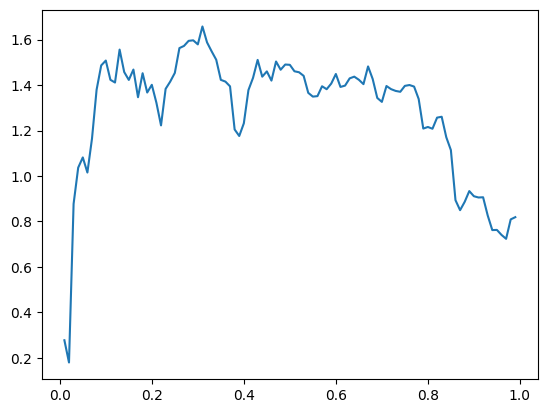

In [424]:
import matplotlib.pyplot as plt
plt.plot(clhl_thresholds, sharp_ratios, label='sharp ratio')

In [425]:
'''Combine the clhl thresholds, sharp ratio, trading days to dataframe'''
df_result = pd.DataFrame({'clhl_threshold': clhl_thresholds, 'sharp_ratio': sharp_ratios, 'trading_days': trading_days})

In [426]:
df_result.head()

,clhl_threshold,sharp_ratio,trading_days
0,0.01,0.277733,4
1,0.02,0.179991,12
2,0.03,0.877478,21
3,0.04,1.036820,30
4,0.05,1.081766,50


In [427]:
'''sort the df_result by sharp_ratio'''
df_result = df_result.sort_values(by='sharp_ratio', ascending=False)

In [428]:
'''Find the best clhl_threshold'''
df_result

,clhl_threshold,sharp_ratio,trading_days
30,0.31,1.657627,262
28,0.29,1.596796,251
27,0.28,1.594433,247
31,0.32,1.587751,270
29,0.30,1.578927,255
...,...,...,...
93,0.94,0.762220,735
95,0.96,0.741047,772
96,0.97,0.723811,793
0,0.01,0.277733,4


In [429]:
df_best  = calculate_clhl(0.31, df_data)

<Axes: xlabel='Date'>

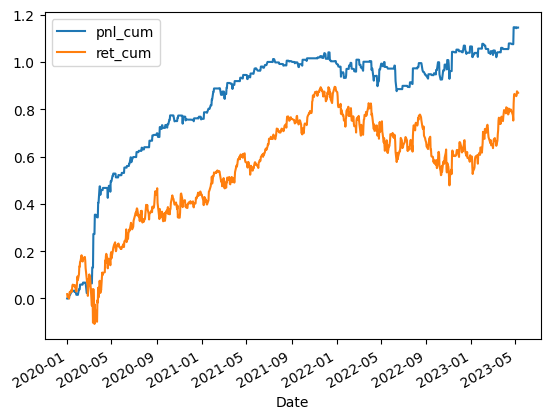

In [430]:
'''compare the active trading return vs buy and hold return'''
df_best[2][['pnl_cum', 'ret_cum']].plot()